In [1]:
# Python standard libraries
import math
import random
import os

# Packages for language model
import nltk
nltk.download('cmudict')
from nltk.corpus import cmudict

# Packages for computation and modelling
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
import mne
import pickle

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Self-defined packages
from swlda import SWLDA
from utils import *

# Magic command to reload packages whenever we run any later cells
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package cmudict to
[nltk_data]     /Users/zionshane/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [2]:
alphabets = [chr(i + ord("A")) for i in range(26)]

lexicon = cmudict.dict().keys()
bigrams = []
for word in lexicon:
    word = word.upper()
    for i in range(len(word)-1):
        if (word[i].isalpha() and word[i+1].isalpha()):
            prev = word[i].upper()
            next = word[i+1].upper()
            bigrams.append((word[i], word[i+1]))

pair_freq = np.zeros(shape=(len(alphabets), len(alphabets)))

for pair in bigrams:
    prev, next = pair
    pair_freq[ord(prev) - ord('A')][ord(next) - ord('A')] += 1

pair_prob = pair_freq / pair_freq.sum(axis=1)[:, None]

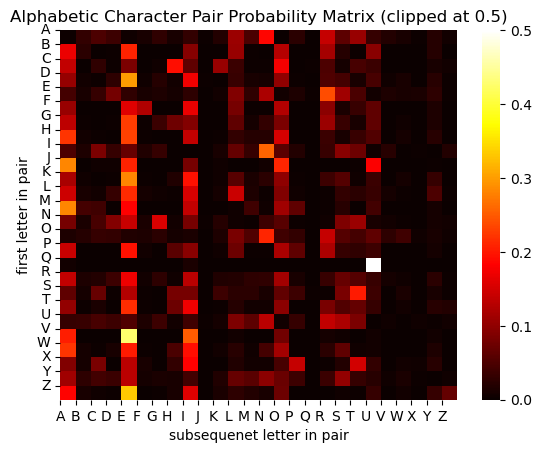

In [3]:
sns.heatmap(pair_prob, cmap='hot', vmin=0, vmax=0.5)
plt.xlabel('subsequenet letter in pair')
plt.xticks(ticks=list(range(len(alphabets))), labels=alphabets, rotation=0)
plt.ylabel('first letter in pair')
plt.yticks(ticks=list(range(len(alphabets))), labels=alphabets, rotation=0)
plt.title('Alphabetic Character Pair Probability Matrix (clipped at 0.5)')
plt.show()

In [4]:
BOARD = [["A",    "B",  "C",   "D",    "E",    "F",     "G",    "H"    ],
         ["I",    "J",  "K",   "L",    "M",    "N",     "O",    "P"    ],
         ["Q",    "R",  "S",   "T",    "U",    "V",     "W",    "X"    ],
         ["Y",    "Z",  "Sp",  "1",    "2",    "3",     "4",    "5"    ],
         ["6",    "7",  "8",   "9",    "0",    "Prd",   "Ret",  "Bs"   ],
         ["?",    ",",  ";",   "\\",   "/",    "+",     "-",    "Alt"  ],
         ["Ctrl", "=",  "Del", "Home", "UpAw", "End",   "PgUp", "Shft" ],
         ["Save", "'",  "F2",  "LfAw", "DnAw", "RtAw",  "PgDn", "Pause"],
         ["Caps", "F5", "Tab", "EC",   "Esc",  "email", "!",    "Sleep"]]
BOARD  = np.array(BOARD)
N_ROWS = BOARD.shape[0]  # number of rows
N_COLS = BOARD.shape[1]  # number of columns
M = N_ROWS * N_COLS      # the number of chars on the board

In [5]:
paradigm       = 'RC'  # display paradigm ('RC', 'CB', or 'RD')
NUM_TIMESTAMPS = 195   # number of timestamps in each window to record signals
EPOCH_SIZE     = 15    # required number of features in every epoch
CORE_CHANNELS = ('EEG_Fz', 'EEG_Cz',  'EEG_P3',  'EEG_Pz',
                 'EEG_P4', 'EEG_PO7', 'EEG_PO8', 'EEG_Oz')
NUM_CORE_CHANNELS  = len(CORE_CHANNELS)  # number of core eletrodes
NUM_TRAIN_WORDS = 6 # number of training words for one participant
NUM_TEST_WORDS  = 6 # number of testing words for one participant
NUM_SEQ = 10        # max number of sequences (all rows and cols are flashed)
T_MAX = (N_ROWS + N_COLS) * NUM_SEQ # max number of flashes

In [43]:
obj_indices = ['01', '02', '03', '04', '05', '06', '07','08', '09', '10', '11',
               '12', '13', '14', '15', '16', '17']

DS_detectabilities = []
DS_AUCs = []
DS_all_performance = []

for obj in obj_indices:
    directory = '/Users/zionshane/Desktop/Duke/Research/BCI_data/EDFData-StudyD'
    obj_directory = directory + f'/D{obj}/SE001'

    train_features,train_response = load_data(p_dir=obj_directory,
                                              obj=obj,
                                              num_timestamps=NUM_TIMESTAMPS,
                                              epoch_size=EPOCH_SIZE,
                                              num_channels=NUM_CORE_CHANNELS,
                                              type=paradigm,
                                              mode='train',
                                              num_words=NUM_TRAIN_WORDS)

    test_features,test_response   = load_data(p_dir=obj_directory,
                                              obj=obj,
                                              num_timestamps=NUM_TIMESTAMPS,
                                              epoch_size=EPOCH_SIZE,
                                              num_channels=NUM_CORE_CHANNELS,
                                              type=paradigm,
                                              mode='test',
                                              num_words=NUM_TEST_WORDS)

    try:
        f = open(f'./model/D{obj}-model.pkl', 'rb')
        clf = pickle.load(f)
    except:
        clf = SWLDA(penter=0.1, premove=0.15)
        clf.fit(train_features, train_response)
        # save the classifier as a standalone model file
        with open(f'./model/D{obj}-model.pkl','wb') as f:
            pickle.dump(clf,f)

    auc = clf.test(train_features, train_response)
    DS_AUCs.append(auc)

    scores = pd.DataFrame(clf.test(train_features), columns=['score'])
    scores['is_target'] = train_response.astype('int')
    mu_1, std_1 = norm.fit(data=scores.loc[scores['is_target'] == 1]['score'])
    mu_0, std_0 = norm.fit(data=scores.loc[scores['is_target'] == 0]['score'])
    var_1 = std_1**2
    var_0 = std_0**2
    DS_detectability = (mu_1 - mu_0) / (math.sqrt((var_1 + var_0)/2))
    DS_detectabilities.append(DS_detectability)

    participant_perform = []

    test_dir = os.fsencode(obj_directory+'/Test/Dyn')
    for test_file in os.scandir(test_dir):
        test_file = os.fsdecode(test_file)
        raw_data = mne.io.read_raw_edf(test_file, preload=True, verbose=False)

        stim_events = mne.find_events(raw=raw_data,
                                      stim_channel='StimulusBegin',
                                      verbose=False)
        eeg_channels = mne.pick_channels_regexp(raw_data.info['ch_names'],'EEG')
        raw_data.notch_filter(freqs=60, picks=eeg_channels, verbose=False)
        test_epochs = get_core_epochs(raw_data)

        current_target_events=mne.find_events(raw_data,
                                              stim_channel='CurrentTarget',
                                              verbose=False)
        current_target = current_target_events[:,2]
        truth = eventIDs_to_sequence(BOARD, current_target)

        phases_events = mne.find_events(raw_data,
                                        stim_channel='PhaseInSequence',
                                        verbose=False)
        phases_appears = phases_events[:,0]
        during_trail_phases = []
        for i in range(1, len(phases_appears), 2):
            start = phases_appears[i]
            end = phases_appears[i+1]
            during_trail_phases.append((start, end))

        test_features, test_response = split_data(test_epochs,
                                                  n_channels=NUM_CORE_CHANNELS,
                                                  n_times=NUM_TIMESTAMPS,
                                                  n_samples=EPOCH_SIZE)
        stim_begin_events=mne.find_events(raw=raw_data,
                                          stim_channel='StimulusBegin',
                                          verbose=False)
        stim_begin_time = stim_begin_events[:,0]

        flashing_schedule=get_flashing_schedule(BOARD,raw_data,stim_begin_time)

        clf_scores = clf.test(data=test_features)

        NUM_SEQ = 10
        T_MAX = (N_ROWS + N_COLS) * NUM_SEQ # max number of flashes per trail
        P_threshold = 0.9

        trail_perform = {'truth':truth, 'select':[], 'times':[]}

        for trail in range(len(during_trail_phases)):
            P_all = np.ones(shape=(N_ROWS, N_COLS)) * (1/M) # Initialize probs
            num_flashes = 0
            target_index = current_target[trail]
            target_loc = ((target_index-1) // N_COLS, (target_index-1) % N_COLS)
            start, end = during_trail_phases[trail]
            time = start

            while time < end:
                num_flashes += 1
                flashed = flashing_schedule[time]
                # Generate the classifier score
                y = clf_scores[num_flashes - 1]
                # Update probabilities
                for i in range(N_ROWS):
                    for j in range(N_COLS):
                        ch_index = N_COLS * i + j + 1
                        if (ch_index in flashed):
                            likelihood=stats.norm.pdf(x=y,loc=mu_1,scale=std_1)
                        else:
                            likelihood=stats.norm.pdf(x=y,loc=mu_0,scale=std_0)
                        P_all[i, j] = P_all[i, j] * likelihood
                # Normalize P_all
                P_all = P_all / P_all.sum()
                # Check if can stop
                if P_all.max() >= P_threshold:
                    break
                else:
                    if num_flashes == T_MAX:
                        break
                    else:
                        time = stim_begin_time[num_flashes]

            max_loc = np.unravel_index(P_all.argmax(), P_all.shape)
            trail_perform['select'].append(BOARD[max_loc])
            trail_perform['times'].append(num_flashes)

        participant_perform.append(trail_perform)

    DS_all_performance.append(participant_perform)

In [44]:
AUC_df = pd.DataFrame({'index': obj_indices, 'AUC': DS_AUCs})
AUC_df.sort_values('AUC', inplace=True)

In [45]:
def count_num_same(list_1, list_2):
    if (len(list_1) != len(list_2)):
        raise ValueError('The two input lists should have the same length!')
    num_same = 0
    for i in range(len(list_1)):
        if (list_1[i] == list_2[i]):
            num_same += 1

    return num_same

In [46]:
DS_accuracies = []
DS_trails = []
for participant_perform in DS_all_performance:
    detailed_trails = [] # for each character
    num_correct = 0
    num_all = 0
    for trail_perform in participant_perform:
        truth  = trail_perform['truth']
        select = trail_perform['select']
        times  = trail_perform['times']
        num_all += len(truth)
        num_correct += count_num_same(truth, select)
        detailed_trails += times
    accuracy = num_correct / num_all
    DS_accuracies.append(accuracy)
    DS_trails.append(detailed_trails)

In [47]:
DS_trails_df = pd.DataFrame({'index': obj_indices, 'trails': DS_trails})
DS_trails_and_AUC_df = pd.merge(AUC_df, DS_trails_df, on="index")
DS_trails_and_AUC_df.sort_values('AUC', inplace=True)

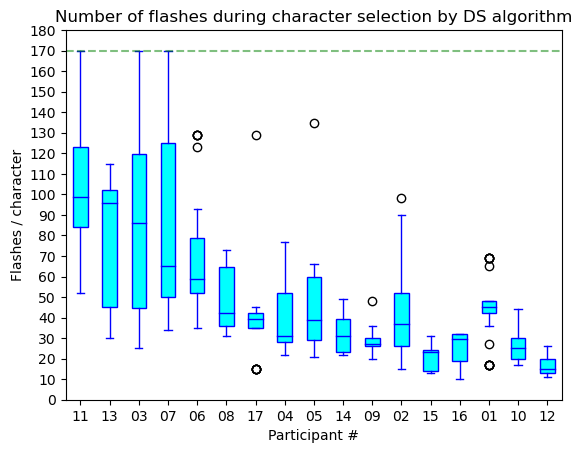

In [65]:
edge_color = 'blue'
fill_color = 'cyan'
bp = plt.boxplot(DS_trails_and_AUC_df['trails'], patch_artist=True)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color=edge_color)
for patch in bp['boxes']:
    patch.set(facecolor=fill_color)

plt.xlabel('Participant #')
plt.xticks(ticks=[i+1 for i in range(len(obj_indices))],
           labels=DS_trails_and_AUC_df['index'])
plt.ylabel('Flashes / character')
plt.ylim(0, 180)
plt.yticks([10*i for i in range(19)])
plt.title('Number of flashes during character selection by DS algorithm')

plt.axhline(y=170, color='green', alpha=0.5, linestyle='--')
plt.show()

In [50]:
obj_indices = ['01', '02', '03', '04', '05', '06', '07','08', '09', '10', '11',
               '12', '13', '14', '15', '16', '17']

DSLM_detectabilities = []
DSLM_AUCs = []
DSLM_all_performance = []

for obj in obj_indices:
    directory = '/Users/zionshane/Desktop/Duke/Research/BCI_data/EDFData-StudyD'
    obj_directory = directory + f'/D{obj}/SE001'

    train_features,train_response = load_data(p_dir=obj_directory,
                                              obj=obj,
                                              num_timestamps=NUM_TIMESTAMPS,
                                              epoch_size=EPOCH_SIZE,
                                              num_channels=NUM_CORE_CHANNELS,
                                              type=paradigm,
                                              mode='train',
                                              num_words=NUM_TRAIN_WORDS)

    test_features,test_response   = load_data(p_dir=obj_directory,
                                              obj=obj,
                                              num_timestamps=NUM_TIMESTAMPS,
                                              epoch_size=EPOCH_SIZE,
                                              num_channels=NUM_CORE_CHANNELS,
                                              type=paradigm,
                                              mode='test',
                                              num_words=NUM_TEST_WORDS)

    try:
        f = open(f'./model/D{obj}-model.pkl', 'rb')
        clf = pickle.load(f)
    except:
        clf = SWLDA(penter=0.1, premove=0.15)
        clf.fit(train_features, train_response)
        # save the classifier as a standalone model file
        with open(f'./model/D{obj}-model.pkl','wb') as f:
            pickle.dump(clf,f)

    auc = clf.test(train_features, train_response)
    DSLM_AUCs.append(auc)

    scores = pd.DataFrame(clf.test(train_features), columns=['score'])
    scores['is_target'] = train_response.astype('int')
    mu_1, std_1 = norm.fit(data=scores.loc[scores['is_target'] == 1]['score'])
    mu_0, std_0 = norm.fit(data=scores.loc[scores['is_target'] == 0]['score'])
    var_1 = std_1**2
    var_0 = std_0**2
    DS_detectability = (mu_1 - mu_0) / (math.sqrt((var_1 + var_0)/2))
    DSLM_detectabilities.append(DS_detectability)

    participant_perform = []

    test_dir = os.fsencode(obj_directory+'/Test/DynBigram')
    for test_file in os.scandir(test_dir):
        test_file = os.fsdecode(test_file)
        raw_data = mne.io.read_raw_edf(test_file, preload=True, verbose=False)

        stim_events = mne.find_events(raw=raw_data,
                                      stim_channel='StimulusBegin',
                                      verbose=False)
        eeg_channels = mne.pick_channels_regexp(raw_data.info['ch_names'],'EEG')
        raw_data.notch_filter(freqs=60, picks=eeg_channels, verbose=False)
        test_epochs = get_core_epochs(raw_data)

        current_target_events=mne.find_events(raw_data,
                                              stim_channel='CurrentTarget',
                                              verbose=False)
        current_target = current_target_events[:,2]
        truth = eventIDs_to_sequence(BOARD, current_target)

        phases_events = mne.find_events(raw_data,
                                        stim_channel='PhaseInSequence',
                                        verbose=False)
        phases_appears = phases_events[:,0]
        during_trail_phases = []
        for i in range(1, len(phases_appears), 2):
            start = phases_appears[i]
            end = phases_appears[i+1]
            during_trail_phases.append((start, end))

        test_features, test_response = split_data(test_epochs,
                                                  n_channels=NUM_CORE_CHANNELS,
                                                  n_times=NUM_TIMESTAMPS,
                                                  n_samples=EPOCH_SIZE)
        stim_begin_events=mne.find_events(raw=raw_data,
                                          stim_channel='StimulusBegin',
                                          verbose=False)
        stim_begin_time = stim_begin_events[:,0]

        flashing_schedule=get_flashing_schedule(BOARD,raw_data,stim_begin_time)

        clf_scores = clf.test(data=test_features)

        NUM_SEQ = 10
        T_MAX = (N_ROWS + N_COLS) * NUM_SEQ # max number of flashes per trail
        P_threshold = 0.9

        trail_perform = {'truth':truth, 'select':[], 'times':[]}

        for trail in range(len(during_trail_phases)):
            P_all = np.ones(shape=(N_ROWS, N_COLS)) * (1/M) # Initialize probs
            num_flashes = 0
            target_index = current_target[trail]
            target_loc = ((target_index-1) // N_COLS, (target_index-1) % N_COLS)
            start, end = during_trail_phases[trail]
            time = start

            while time < end:
                num_flashes += 1
                flashed = flashing_schedule[time]
                # Generate the classifier score
                y = clf_scores[num_flashes - 1]
                # Update probabilities
                for i in range(N_ROWS):
                    for j in range(N_COLS):
                        ch_index = N_COLS * i + j + 1
                        if (ch_index in flashed):
                            likelihood=stats.norm.pdf(x=y,loc=mu_1,scale=std_1)
                        else:
                            likelihood=stats.norm.pdf(x=y,loc=mu_0,scale=std_0)
                        P_all[i, j] = P_all[i, j] * likelihood
                # Normalize P_all
                P_all = P_all / P_all.sum()
                # Check if can stop
                if P_all.max() >= P_threshold:
                    break
                else:
                    if num_flashes == T_MAX:
                        break
                    else:
                        time = stim_begin_time[num_flashes]

            max_loc = np.unravel_index(P_all.argmax(), P_all.shape)
            trail_perform['select'].append(BOARD[max_loc])
            trail_perform['times'].append(num_flashes)

        participant_perform.append(trail_perform)

    DSLM_all_performance.append(participant_perform)

In [51]:
DSLM_accuracies = []
DSLM_trails = []
for participant_perform in DSLM_all_performance:
    detailed_trails = [] # for each character
    num_correct = 0
    num_all = 0
    for trail_perform in participant_perform:
        truth  = trail_perform['truth']
        select = trail_perform['select']
        times  = trail_perform['times']
        num_all += len(truth)
        num_correct += count_num_same(truth, select)
        detailed_trails += times
    accuracy = num_correct / num_all
    DSLM_accuracies.append(accuracy)
    DSLM_trails.append(detailed_trails)

In [52]:
DSLM_trails_df = pd.DataFrame({'index': obj_indices, 'trails': DSLM_trails})
DSLM_trails_and_AUC_df = pd.merge(AUC_df, DSLM_trails_df, on="index")
DSLM_trails_and_AUC_df.sort_values('AUC', inplace=True)

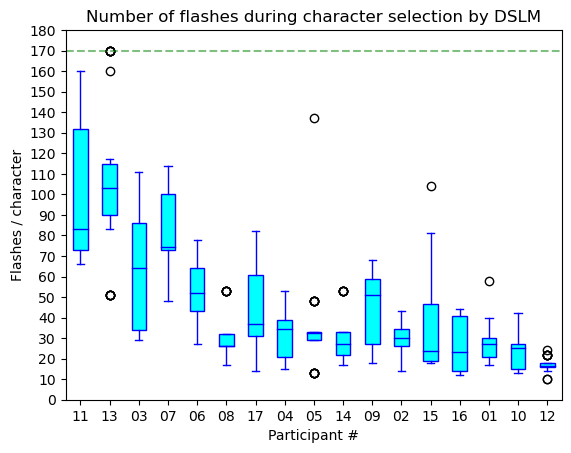

In [64]:
edge_color = 'blue'
fill_color = 'cyan'
bp = plt.boxplot(DSLM_trails_and_AUC_df['trails'], patch_artist=True)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color=edge_color)
for patch in bp['boxes']:
    patch.set(facecolor=fill_color)

plt.xlabel('Participant #')
plt.xticks(ticks=[i+1 for i in range(len(obj_indices))],
           labels=DSLM_trails_and_AUC_df['index'])
plt.ylabel('Flashes / character')
plt.ylim(0, 180)
plt.yticks([10*i for i in range(19)])
plt.title('Number of flashes during character selection by DSLM')

plt.axhline(y=170, color='green', alpha=0.5, linestyle='--')
plt.show()

In [56]:
DS_accuracies_df = pd.DataFrame({'index': obj_indices, 'accuracy': DS_accuracies})
DS_accuracies_and_AUC_df = pd.merge(AUC_df, DS_accuracies_df, on="index")

DSLM_accuracies_df = pd.DataFrame({'index': obj_indices, 'accuracy': DSLM_accuracies})
DSLM_accuracies_and_AUC_df = pd.merge(AUC_df, DSLM_accuracies_df, on="index")

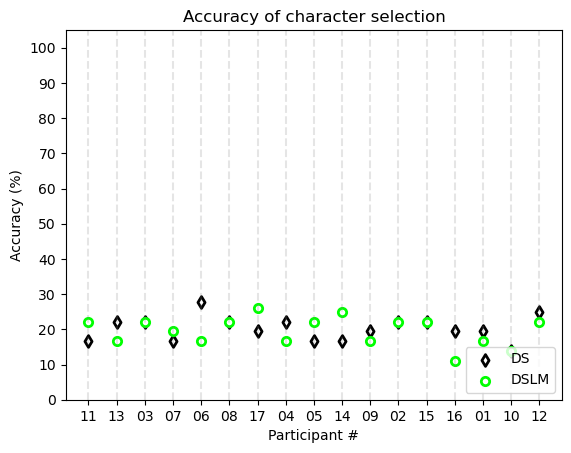

In [57]:
plt.scatter(x=[i+1 for i in range(len(obj_indices))],
            y=DS_accuracies_and_AUC_df['accuracy'], lw=2,
            color='white', edgecolors='black', marker='d', label='DS')

plt.scatter(x=[i+1 for i in range(len(obj_indices))],
            y=DSLM_accuracies_and_AUC_df['accuracy'], lw=2,
            color='white', edgecolors='lime', marker='o', label='DSLM')

plt.xlabel('Participant #')
plt.xticks(ticks=[i+1 for i in range(len(obj_indices))], labels=AUC_df['index'])
plt.ylabel('Accuracy (%)')
plt.ylim(0, 1+0.05)
plt.yticks([0.1*i for i in range(11)], [10*i for i in range(11)])
plt.title('Accuracy of character selection')
plt.legend(loc=4)

for i in range(len(obj_indices)):
    plt.axvline(x=i+1, color='gray', alpha=0.2, linestyle='--')
plt.show()

In [58]:
DS_average_trials = [sum(trails) / len(trails) for trails in DS_trails]
DS_average_trials_df = pd.DataFrame({'index': obj_indices,
                                     'avg_trails': DS_average_trials})
DS_average_trials_and_AUC_df = pd.merge(AUC_df, DS_average_trials_df, on="index")

DSLM_average_trials = [sum(trails) / len(trails) for trails in DSLM_trails]
DSLM_average_trials_df = pd.DataFrame({'index': obj_indices,
                                       'avg_trails': DSLM_average_trials})
DSLM_average_trials_and_AUC_df = pd.merge(AUC_df, DSLM_average_trials_df, on="index")

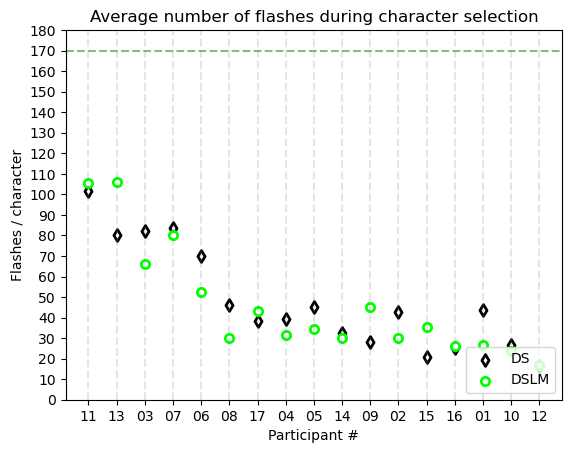

In [63]:
plt.scatter(x=[i+1 for i in range(len(obj_indices))],
            y=DS_average_trials_and_AUC_df['avg_trails'], lw=2,
            color='white', edgecolors='black', marker='d', label='DS')

plt.scatter(x=[i+1 for i in range(len(obj_indices))],
            y=DSLM_average_trials_and_AUC_df['avg_trails'], lw=2,
            color='white', edgecolors='lime', marker='o', label='DSLM')

plt.xlabel('Participant #')
plt.xticks(ticks=[i+1 for i in range(len(obj_indices))], labels=AUC_df['index'])
plt.ylabel('Flashes / character')
# plt.ylim(0, 130)
plt.yticks([10*i for i in range(19)])
plt.title('Average number of flashes during character selection')
plt.legend(loc=4)

plt.axhline(y=170, color='green', alpha=0.5, linestyle='--')
for i in range(len(obj_indices)):
    plt.axvline(x=i+1, color='gray', alpha=0.2, linestyle='--')
plt.show()